# Grid search for hyperparameter tunning (includes gate speed and grip strength)

# Import and setup


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from IPython.display import display, clear_output
import time
import itertools
import os
import sys


notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from mop_model import MoPModel as MoP_raw, MoPConfig


# Trainning and evaluation functions

In [2]:
def train_and_evaluate_trial_mop(params, X_train, y_train, X_val, y_val):
    """
    Trains and evaluates a single trial of the MoP model with a given set of hyperparameters.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # --- Model Configuration ---
    config = MoPConfig(
        input_dim=X_train.shape[1],
        output_dim=2,
        intermediate_dim=params['intermediate_dim'],
        layers=params['layers']
    )
    model = MoP_raw(config).to(device)
    
    # --- Data Preparation ---
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.LongTensor(y_val).to(device)

    # --- Training with Early Stopping ---
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    patience = 5
    best_val_loss = float('inf')
    patience_counter = 0
    max_epochs = 75

    for epoch in range(max_epochs):
        model.train()
        optimizer.zero_grad()
        # MoP expects a sequence dimension
        y_pred, usage_losses, entropy_loss = model(X_train_tensor.unsqueeze(1))
        y_pred = y_pred.squeeze(1)
        
        # MoP auxiliary losses can be added here for more robust training
        class_loss = criterion(y_pred, y_train_tensor)
        total_loss = class_loss # For simplicity, we only use class_loss for early stopping
        
        total_loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            y_val_pred, _, _ = model(X_val_tensor.unsqueeze(1))
            val_loss = criterion(y_val_pred.squeeze(1), y_val_tensor)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            break

    # --- Final Evaluation on Validation Set ---
    model.eval()
    with torch.no_grad():
        y_pred_tensor, _, _ = model(X_val_tensor.unsqueeze(1))
        y_pred_tensor = y_pred_tensor.squeeze(1)
        probas = nn.functional.softmax(y_pred_tensor, dim=1)
        _, predicted = torch.max(probas, 1)
        
        y_true = y_val_tensor.cpu().numpy()
        y_pred = predicted.cpu().numpy()
        y_score = probas[:, 1].cpu().numpy()
        
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0).get('1', {})

        return {
            'intermediate_dim': params['intermediate_dim'],
            'layers': str(params['layers']), # Convert list to string for display
            'val_roc_auc': roc_auc_score(y_true, y_score),
            'val_accuracy': accuracy_score(y_true, y_pred),
            'val_f1_score': report.get('f1-score', 0),
            'val_precision': report.get('precision', 0),
            'val_recall': report.get('recall', 0),
            'val_cohen_kappa': cohen_kappa_score(y_true, y_pred)
        }


# Data Loading and Hyperparameter definition

In [ ]:
# --- 1. Load and Prepare Data ---
try:
    print("🔹 Loading and preparing data...")
    filename = 'input_mop_original.csv'
    current_dir = os.getcwd()
    parent_dir = os.path.dirname(current_dir)
    file_path = os.path.join(parent_dir, filename)
    df = pd.read_csv(file_path, low_memory=False)
    X = df.drop(columns=['Dementia Status'])
    y = df['Dementia Status']
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Data loaded successfully. Train shape: {X_train.shape}")
except FileNotFoundError:
    print("\n⚠️ ERROR: 'input_data.csv' not found. Please run the feature extractor first.")
    # In a notebook, you might want to stop execution here if the file is not found.

# --- 2. Define the Hyperparameter Grid for MoP ---
param_grid = {
    'intermediate_dim': [32, 64, 96, 128],
    'layers': [
        ["0,8,16", "0,8,16", "0,8,16"],      # Three simple layers
        ["0,16,32", "0,16,32", "0,16,32"],    # Three more complex layers
        ["0,8,16", "0,16,32", "0,8,16"],      # A mix of simple and complex layers
        ["0,16,32", "0,8,16", "0,16,32"]       # Another mix
    ]
}

# Create all possible combinations
valid_params = [
    {'intermediate_dim': p[0], 'layers': p[1]}
    for p in itertools.product(param_grid['intermediate_dim'], param_grid['layers'])
]

print(f"\n🔹 Starting Grid Search for MoP. Total combinations to test: {len(valid_params)}")


🔹 Loading and preparing data...
Data loaded successfully. Train shape: (1297, 57)

🔹 Starting Grid Search for MoP. Total combinations to test: 16


# Run grid search and final evaluation

In [4]:
final_results={}
final_results["val_cohen_kappa"]=0
while final_results["val_cohen_kappa"]<0.50:
    # --- 3. Run the Grid Search for MoP ---
    results = []
    for i, params in enumerate(valid_params):
        print(f"\n--- Testing Combination {i+1}/{len(valid_params)} ---")
        print(f"Parameters: {params}")
        
        result = train_and_evaluate_trial_mop(params, X_train_scaled, y_train.values, X_val_scaled, y_val.values)
        results.append(result)
        
        # Live update of results
        clear_output(wait=True)
        # --- CHANGE: Sort by validation accuracy ---
        results_df = pd.DataFrame(results).sort_values('val_accuracy', ascending=False)
        print("✅ Intermediate Tuning Results for MoP (Validation Set):")
        display(results_df)

    # --- 4. Final Evaluation on Test Set ---
    print("\n\n" + "="*40 + "\n✅ FINAL MoP EVALUATION ON HELD-OUT TEST SET\n" + "="*40)

    # Get the best parameters from the grid search
    best_params = results_df.iloc[0].to_dict()
    # --- CHANGE: Update print statement to reflect accuracy ---
    print("🏆 Best MoP Hyperparameters found (based on validation Accuracy):")
    print(f"  - Intermediate Dimension: {int(best_params['intermediate_dim'])}")
    print(f"  - Layer Structure: {best_params['layers']}")

    # Combine training and validation data
    X_train_val = np.concatenate((X_train_scaled, X_val_scaled), axis=0)
    y_train_val = np.concatenate((y_train.values, y_val.values), axis=0)

    print("\nRetraining the best MoP model on combined Train+Validation data...")

    # Create the final model with the best parameters
    final_config = MoPConfig(
        input_dim=X_train_val.shape[1],
        output_dim=2,
        intermediate_dim=int(best_params['intermediate_dim']),
        layers=eval(best_params['layers']) # Use eval to convert string back to list
    )
    final_model = MoP_raw(final_config)

    # Train the final model and evaluate on the test set
    # We reuse the same function, but the validation set is now the test set
    final_results = train_and_evaluate_trial_mop(
        {'intermediate_dim': int(best_params['intermediate_dim']), 'layers': eval(best_params['layers'])},
        X_train_val, y_train_val, X_test_scaled, y_test.values
    )

    print("\n--- Final MoP Performance on Test Set ---")
    print(f"  - Accuracy:    {final_results['val_accuracy']:.4f}")
    print(f"  - ROC-AUC:     {final_results['val_roc_auc']:.4f}")
    print(f"  - F1-Score:    {final_results['val_f1_score']:.4f}")
    print(f"  - Precision:   {final_results['val_precision']:.4f}")
    print(f"  - Recall:      {final_results['val_recall']:.4f}")
    print(f"  - Cohen Kappa: {final_results['val_cohen_kappa']:.4f}")


✅ Intermediate Tuning Results for MoP (Validation Set):


,intermediate_dim,layers,val_roc_auc,val_accuracy,val_f1_score,val_precision,val_recall,val_cohen_kappa
1,32,"['0,16,32', '0,16,32', '0,16,32']",0.774732,0.726619,0.753247,0.694611,0.822695,0.451648
7,64,"['0,16,32', '0,8,16', '0,16,32']",0.775457,0.723022,0.744186,0.700000,0.794326,0.444836
0,32,"['0,8,16', '0,8,16', '0,8,16']",0.771911,0.719424,0.745098,0.690909,0.808511,0.437335
9,96,"['0,16,32', '0,16,32', '0,16,32']",0.770254,0.712230,0.735099,0.689441,0.787234,0.423147
13,128,"['0,16,32', '0,16,32', '0,16,32']",0.763731,0.712230,0.733333,0.691824,0.780142,0.423266
3,32,"['0,16,32', '0,8,16', '0,16,32']",0.768572,0.708633,0.732673,0.685185,0.787234,0.415875
6,64,"['0,8,16', '0,16,32', '0,8,16']",0.772040,0.708633,0.727273,0.692308,0.765957,0.416239
10,96,"['0,8,16', '0,16,32', '0,8,16']",0.770073,0.708633,0.732673,0.685185,0.787234,0.415875
11,96,"['0,16,32', '0,8,16', '0,16,32']",0.758425,0.705036,0.721088,0.692810,0.751773,0.409216
12,128,"['0,8,16', '0,8,16', '0,8,16']",0.768209,0.705036,0.724832,0.687898,0.765957,0.408971




✅ FINAL MoP EVALUATION ON HELD-OUT TEST SET
🏆 Best MoP Hyperparameters found (based on validation Accuracy):
  - Intermediate Dimension: 32
  - Layer Structure: ['0,16,32', '0,16,32', '0,16,32']

Retraining the best MoP model on combined Train+Validation data...

--- Final MoP Performance on Test Set ---
  - Accuracy:    0.7554
  - ROC-AUC:     0.8171
  - F1-Score:    0.7718
  - Precision:   0.7278
  - Recall:      0.8214
  - Cohen Kappa: 0.5103


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html




🚀 Starting SHAP Analysis for the Best Model
Calculating SHAP values... (This may take a moment)

--- SHAP Summary Plots ---


Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


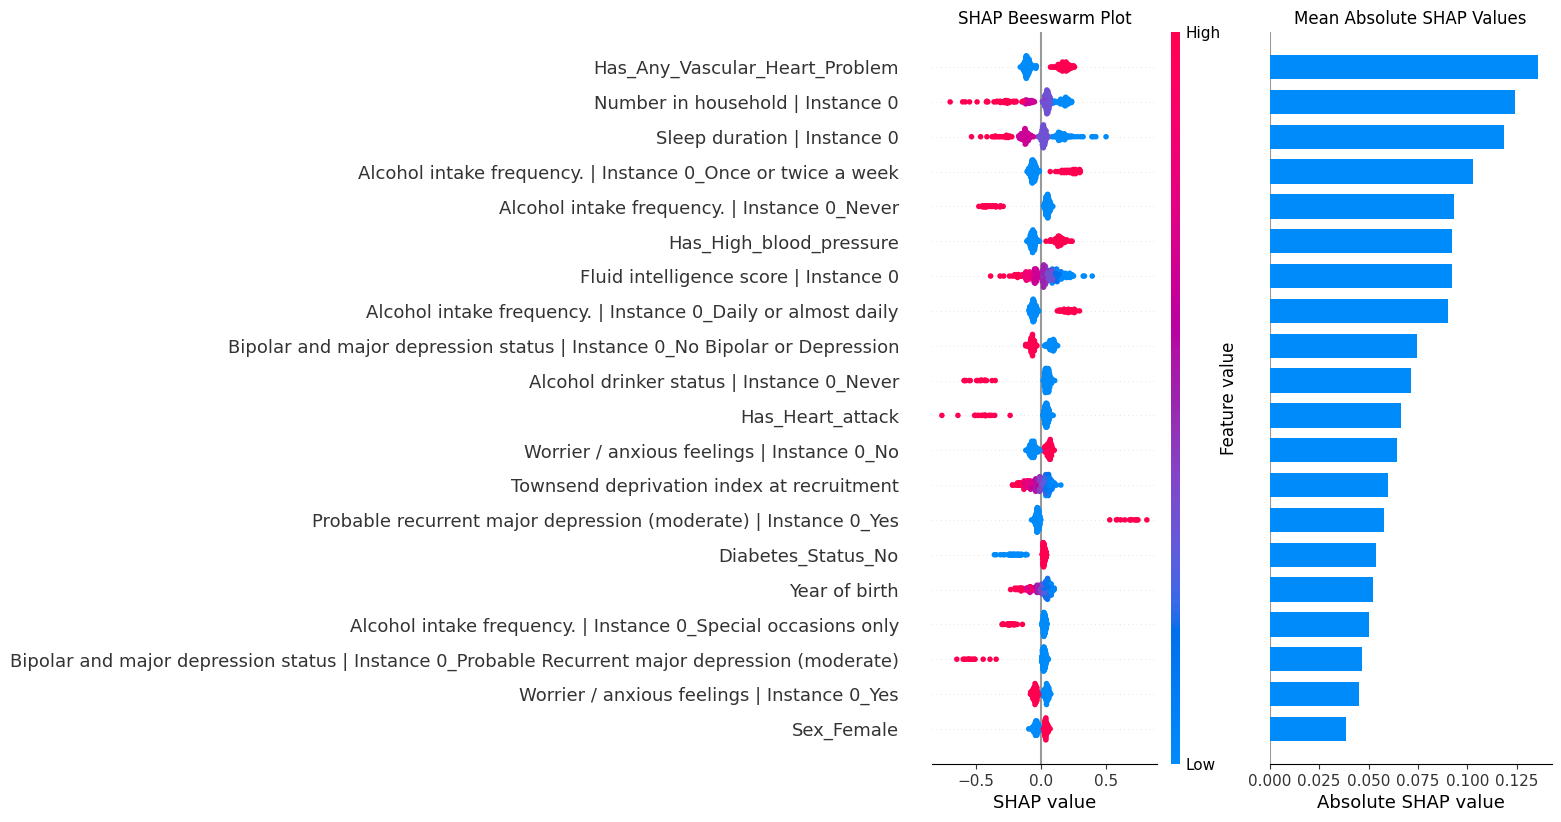

In [5]:
import shap
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# ===================================================================
# SHAP Analysis of the Final, Best Model
# ===================================================================
# This block should be run after the hyperparameter tuning is complete.
# It uses the 'final_model' and the scaled data from the previous cell.
# ===================================================================

print("\n\n" + "="*40 + "\n🚀 Starting SHAP Analysis for the Best Model\n" + "="*40)

# --- 1. Prepare the model and data for SHAP ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# The final_model is already trained and on the correct device.
# We just need to ensure it's in evaluation mode.
final_model.eval()

# SHAP needs a background dataset to compute expected values.
# We'll use a sample of the training data for this.
background_sample = shap.sample(X_train_scaled, 100)
background_tensor = torch.from_numpy(background_sample).float().to(device)

# We will explain the model's predictions on the test set.
test_tensor = torch.from_numpy(X_test_scaled).float().to(device)

# --- 2. Create a wrapper for the SHAP explainer ---
# This ensures SHAP correctly handles the PyTorch model.
class ShapModelWrapper(nn.Module):
    def __init__(self, model):
        super(ShapModelWrapper, self).__init__()
        self.model = model
    
    def forward(self, x):
        # Temporarily switch to train() mode for the forward pass
        # to allow the backward pass required by the explainer.
        self.model.train()
        
        # The MoP model expects a 3D tensor with a sequence length of 1.
        pred, _, _ = self.model(x.unsqueeze(1))
        return pred.squeeze(1)

shap_model_wrapper = ShapModelWrapper(final_model)

# Explicitly move the entire wrapper (including the model inside it) to the correct device.
shap_model_wrapper.to(device)


# --- 3. Calculate SHAP values ---
# We use GradientExplainer, which is robust for this type of model.
explainer = shap.GradientExplainer(shap_model_wrapper, background_tensor)

print("Calculating SHAP values... (This may take a moment)")
shap_values = explainer.shap_values(test_tensor)

# --- 4. Generate and display the summary plots ---
print("\n--- SHAP Summary Plots ---")
# For binary classification, we plot the SHAP values for the positive class (class 1)

# --- THIS IS THE FIX: Manually create subplots and control each one ---
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plot 1: Beeswarm Plot
# Use plt.sca to set the current axis for SHAP to draw on
plt.sca(axes[0])
shap.summary_plot(shap_values[1], features=X_test_scaled, feature_names=X.columns, plot_type="dot", show=False)
axes[0].set_title("SHAP Beeswarm Plot")
axes[0].set_xlabel("SHAP value")

# Plot 2: Bar Plot (Mean absolute values)
plt.sca(axes[1])
shap.summary_plot(shap_values[1], features=X_test_scaled, feature_names=X.columns, plot_type="bar", show=False)
axes[1].set_title("Mean Absolute SHAP Values")
# Manually remove the y-axis labels from the second plot
axes[1].set_ylabel('')
axes[1].set_yticklabels([])
axes[1].set_xlabel("Absolute SHAP value")

# Use the figure's tight_layout method for a final adjustment
fig.tight_layout()
plt.show()
